In [1]:
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision
import torchvision.transforms as transforms
import os, glob
import numpy as np
import random
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import sys
sys.path.append('../')
from src.utils import *

(375, 1242, 3)

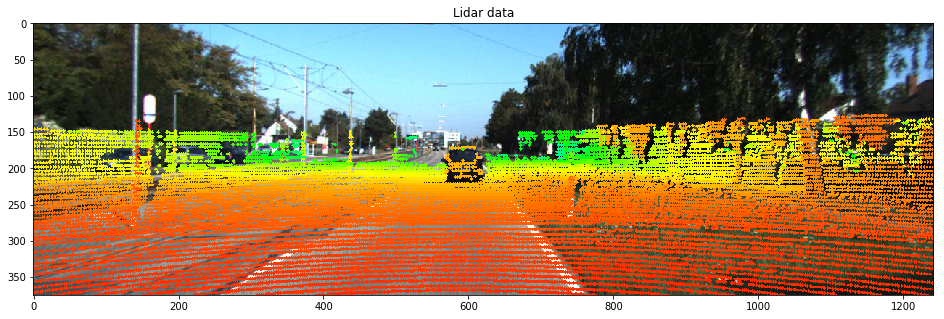

In [2]:
im_left_dir = './data/left_imgs/'
gt_left_dir = './data/left_gt/'
im_right_dir = './data/right_imgs/'
gt_right_dir = './data/right_gt/'

idx = random.randint(0, 100)
im_left = mpimg.imread(os.path.join('data/right_imgs/2011_09_26_drive_0015_sync', ("{:010}".format(idx) + '.jpg')))
c = os.path.join('data/right_gt/2011_09_26_drive_0015_sync', ("{:010}".format(idx) + '.npy')) 
d = np.load(c)
show_lidar(im_left, d)

im_left.shape

In [6]:
class KittiStereoLidar(Dataset):
    def __init__(self, im_left_dir, im_right_dir, gt_left_dir, gt_right_dir, transform=None):
        self.im_left_dir = im_left_dir
        self.im_right_dir = im_right_dir
        self.gt_left_dir = gt_left_dir
        self.gt_right_dir = gt_right_dir
        
        self.im_left_dir.sort()
        self.im_right_dir.sort()
        self.gt_left_dir.sort()
        self.gt_right_dir.sort()
        
        self.transform = transform
        
    def __getitem__(self, index):
        iml = Image.open(self.im_left_dir[index])
        imr = Image.open(self.im_right_dir[index])
        gtl = self.gt_left_dir[index]
        gtr = self.gt_right_dir[index]

        if self.transform:
            iml = self.transform(iml)
            imr = self.transform(imr)

        return iml, imr, gtl, gtr
    
    def __len__(self):
        return len(self.im_left_dir)

im_left_dir=glob.glob("data/left_imgs/*/*")
im_right_dir = glob.glob("data/right_imgs/*/*")
gt_left_dir=glob.glob("data/left_gt/*/*")
gt_right_dir=glob.glob("data/right_gt/*/*")

kitti_ds = KittiStereoLidar(
    im_left_dir=im_left_dir, 
    im_right_dir=im_right_dir,
    gt_left_dir=gt_left_dir, 
    gt_right_dir=gt_right_dir,
    transform=transforms.ToTensor())

In [ ]:
batch_size = 64
train_loader = DataLoader(dataset=kitti_ds, 
                          batch_size=batch_size, 
                          shuffle=True, 
                          num_workers=4)
 
dataiter = iter(train_loader)

data/right_gt/2011_09_30_drive_0028_sync/0000005066.npy


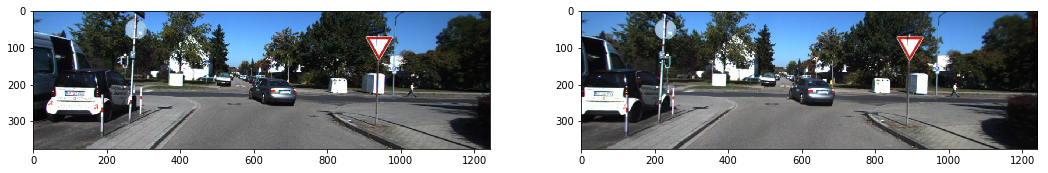

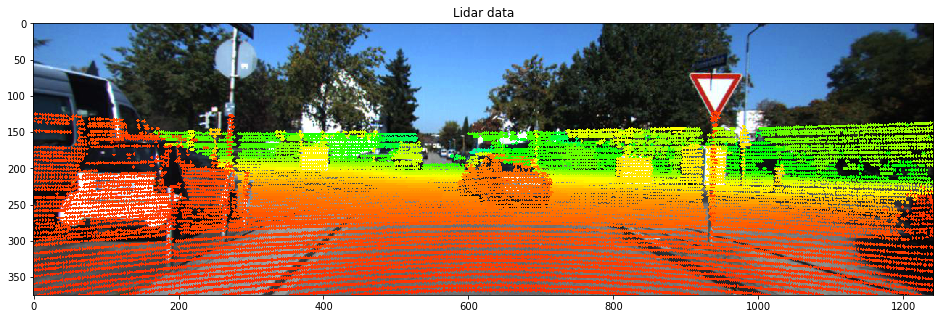

In [8]:
def imshow(iml, imr):
    npl = iml.numpy()
    npr = imr.numpy()
    f, (ax1, ax2)=plt.subplots(1,2,figsize=(18,6))
    ax1.imshow(np.transpose(npl, (1, 2, 0)))
    ax2.imshow(np.transpose(npr, (1, 2, 0)))

images_l, images_r, scans_l, scans_r = dataiter.next()
idx = random.randint(0, batch_size)
imshow(images_l[idx], images_r[idx])

print(scans_r[idx])
scr = np.load(scans_l[idx])
npr = np.transpose(images_l[idx].numpy(), (1,2,0))
show_lidar(npr, scr)

In [2]:
from src.dataset import *

In [6]:
kitti_ds = KittiStereoLidarGray(
    im_left_dir=glob.glob("../data/left_imgs/2011_09_26_drive_0001_sync/*"), 
    im_right_dir=glob.glob("../data/right_imgs/2011_09_26_drive_0001_sync/*"),
    gt_left_dir=glob.glob("../data/left_gt/2011_09_26_drive_0001_sync/*"), 
    gt_right_dir=glob.glob("../data/right_gt/2011_09_26_drive_0001_sync/*"),
    transform=transforms.Compose([transforms.Resize((192,640)),
                                  transforms.Grayscale(),
                                  transforms.ToTensor()])
)

In [7]:
batch_size = 4
train_loader = DataLoader(dataset=kitti_ds, 
                          batch_size=batch_size, 
                          shuffle=True, 
                          num_workers=6)
 
dataiter = iter(train_loader)

torch.Size([4, 3, 192, 640])
(3, 192, 640)
../data/right_gt/2011_09_26_drive_0001_sync/0000000105.npy


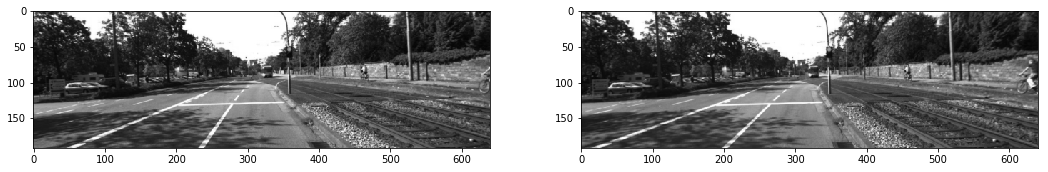

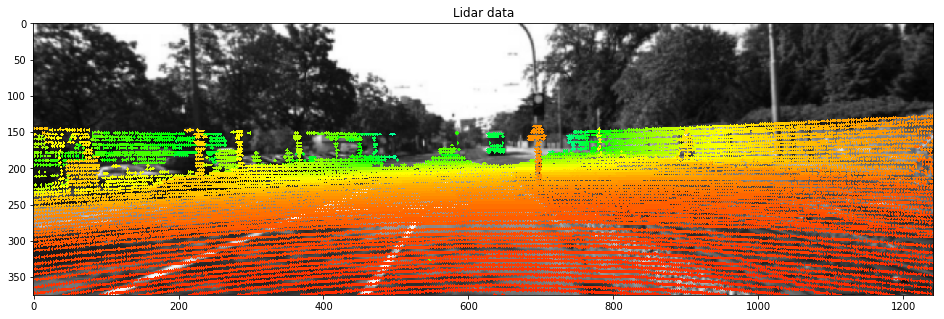

In [8]:
def imshow(iml, imr):
    npl = iml.numpy()
    npr = imr.numpy()
    f, (ax1, ax2)=plt.subplots(1,2,figsize=(18,6))
    print(npl.shape)
    ax1.imshow(np.transpose(npl, (1, 2, 0)))
    ax2.imshow(np.transpose(npr, (1, 2, 0)))

images_l, images_r, scans_l, scans_r = dataiter.next()
print(images_l.shape)
idx = random.randint(0, batch_size-1)
imshow(images_l[idx], images_r[idx])

print(scans_r[idx])
scr = np.load(scans_l[idx])
npr = np.transpose(images_l[idx].numpy(), (1,2,0))
npr = cv2.resize(npr, (1242, 375))
show_lidar(npr, scr)

In [16]:
im_left = mpimg.imread(os.path.join('../data/right_imgs/2011_09_26_drive_0015_sync', ("{:010}".format(idx) + '.jpg')))

In [42]:
im_hls = cv2.cvtColor(im_left, cv2.COLOR_RGB2HLS)

In [45]:
im_hls[:,:,1] = np.ones([im_hls.shape[0], im_hls.shape[1]])*100

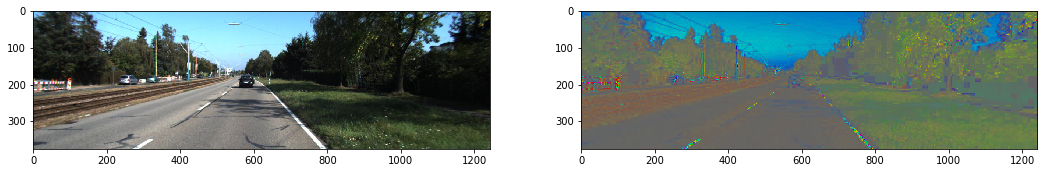

In [46]:
im_processed = cv2.cvtColor(im_hls, cv2.COLOR_HLS2RGB)
f, (ax1, ax2)=plt.subplots(1,2,figsize=(18,6))
ax1.imshow(im_left)
ax2.imshow(im_processed)
plt.show()